In [1]:
import os
import re
import math
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import networkx as nx

from wordcloud import WordCloud
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')
#nlp.remove_pipe('tagger')

import gensim
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [2]:
input_dir = 'data'
#print(os.listdir(input_dir))

professionals = pd.read_csv(os.path.join(input_dir, 'professionals.csv'))
groups = pd.read_csv(os.path.join(input_dir, 'groups.csv'))
comments = pd.read_csv(os.path.join(input_dir, 'comments.csv'))
school_memberships = pd.read_csv(os.path.join(input_dir, 'school_memberships.csv'))
tags = pd.read_csv(os.path.join(input_dir, 'tags.csv'))
emails = pd.read_csv(os.path.join(input_dir, 'emails.csv'))
group_memberships = pd.read_csv(os.path.join(input_dir, 'group_memberships.csv'))
answers = pd.read_csv(os.path.join(input_dir, 'answers.csv'))
students = pd.read_csv(os.path.join(input_dir, 'students.csv'))
matches = pd.read_csv(os.path.join(input_dir, 'matches.csv'))
questions = pd.read_csv(os.path.join(input_dir, 'questions.csv'))
tag_users = pd.read_csv(os.path.join(input_dir, 'tag_users.csv'))
tag_questions = pd.read_csv(os.path.join(input_dir, 'tag_questions.csv'))
answer_scores = pd.read_csv(os.path.join(input_dir, 'answer_scores.csv'))
question_scores = pd.read_csv(os.path.join(input_dir, 'question_scores.csv'))

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

seed = 13
random.seed(seed)
np.random.seed(seed)

In [4]:
print(f"""professionals - {professionals.columns} \n
students - {students.columns} \n\n questions - {questions.columns} \n
answers - {answers.columns}
""")

professionals - Index(['professionals_id', 'professionals_location', 'professionals_industry',
       'professionals_headline', 'professionals_date_joined'],
      dtype='object') 

students - Index(['students_id', 'students_location', 'students_date_joined'], dtype='object') 

 questions - Index(['questions_id', 'questions_author_id', 'questions_date_added',
       'questions_title', 'questions_body'],
      dtype='object') 

answers - Index(['answers_id', 'answers_author_id', 'answers_question_id',
       'answers_date_added', 'answers_body'],
      dtype='object')



In [5]:
question_scores.columns, answer_scores.columns, tag_questions.columns

(Index(['id', 'score'], dtype='object'),
 Index(['id', 'score'], dtype='object'),
 Index(['tag_questions_tag_id', 'tag_questions_question_id'], dtype='object'))

### Features extraction

#### tokenize POS

In [6]:
# Spacy Tokenfilter for part-of-speech tagging
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']

# The data export was from 1. February 2019. For Production use datetime.now()
actual_date = datetime(2019, 2 ,1)

In [7]:
def nlp_preprocessing(data):
    """ Use NLP to transform the text corpus to cleaned sentences and word tokens

        param data: List with sentences, which should be processed.
        return processed_tokens: List with the cleaned and tokenized sentences
    """    
    def token_filter(token):
        """ Keep tokens who are alphapetic, in the pos (part-of-speech) list and not in stop list
            
        """    
        return not token.is_stop and token.is_alpha and token.pos_ in token_pos
    
    data = [re.compile(r'<[^>]+>').sub('', x) for x in data] #Remove HTML-tags
    processed_tokens = []
    data_pipe = nlp.pipe(data)
    for doc in data_pipe:
        filtered_tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        processed_tokens.append(filtered_tokens)
    return processed_tokens

### Features
First we transform the datetime columns (`date_added` and `date_joined`), so that we can work with time delta functions.  
After this we create the following new columns:  

**DataFrame Questions:**  
* **questions_full_text:** Merge the questions title with the body for later use of NLP.  
* **questions_answers_count:** How many answers a question has.  
* **questions_first_answers:** The timestamp for the first answer of the question.  
* **questions_last_answers:** The timestamp for the last answer of the question.  
* **questions_hearts:** Hearts score for the question.  
* **questions_tags:** List with tags for the question.  
* **nlp_tokens:** Extract relevant tokens from the question full text.  

**DataFrame Answers:**  
* **time_delta_answert:** Time delta from question to answer.  
* **answers_time_rank:** Ranking for time to answer the question.  
* **answers_hearts:** Hearts score for the answer.

**DataFrame Professionals:**  
* **professionals_time_delta_joined:** Time since creating the account.  
* **professionals_answers_count:** Number of written answers.  
* **professionals_comments_count:** Number of written comments.  
* **date_last_answer:** Date last answer.  
* **date_first_answer:** Date first answer.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (answer or comment).  
* **date_first_activity:** Date first activity (answer or comment).  
* **professional_answers_hearts:** Hearts score for all answers. 
* **professional_tags:** List with tags for the professional.  

**DataFrame Students:**  
* **students_time_delta_joined:** Time since creating the account.  
* **students_questions_count:** Number of written questions.  
* **students_comments_count:** Number of written comments.  
* **date_last_questions:** Date last question.  
* **date_first_questions:** Date first question.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (question or comment).  
* **date_first_activity:** Date first activity (question or comment).  
* **students_questions_hearts:** Hearts score for all questions.  
* **students_tags:** List with tags for the students.  

**New DataFrame emails_response:**  
Has the response activity from professionals to emails and additional informations about the questions behind.
* **time_delta_email_answer:** Time needed the question was answered after the email was send.  
* **time_delta_question_email:** Time needed the email was send after the questions was written.

In [8]:
# Transform datetime datatypes
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)


### Questions

In [9]:
# Merge Question Title and Body
questions['questions_full_text'] = questions['questions_title'] +'\r\n\r\n'+ questions['questions_body']

In [10]:
# Count of answers for a question
temp = answers.groupby('answers_question_id').size()
questions['questions_answers_count'] = pd.merge(questions, pd.DataFrame(temp.rename('count')), left_on='questions_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [11]:
# First answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()
questions['questions_first_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

In [12]:
# Last answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').max()
questions['questions_last_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

In [13]:
# Hearts Score
temp = pd.merge(questions, question_scores, left_on='questions_id', right_on='id', how='left')
questions['questions_hearts'] = temp['score'].fillna(0).astype(int)

In [14]:
questions.columns,tags.columns, tag_questions.columns , questions.shape,tags.shape, tag_questions.shape, tags.head(),tag_questions.head()

(Index(['questions_id', 'questions_author_id', 'questions_date_added',
        'questions_title', 'questions_body', 'questions_full_text',
        'questions_answers_count', 'questions_first_answers',
        'questions_last_answers', 'questions_hearts'],
       dtype='object'),
 Index(['tags_tag_id', 'tags_tag_name'], dtype='object'),
 Index(['tag_questions_tag_id', 'tag_questions_question_id'], dtype='object'),
 (23931, 10),
 (16269, 2),
 (76553, 2),
    tags_tag_id      tags_tag_name
 0  27490        college          
 1  461          computer-science 
 2  593          computer-software
 3  27292        business         
 4  18217        doctor           ,
    tag_questions_tag_id         tag_questions_question_id
 0  28930                 cb43ebee01364c68ac61d347a393ae39
 1  28930                 47f55e85ce944242a5a347ab85a8ffb4
 2  28930                 ccc30a033a0f4dfdb2eb987012f25792
 3  28930                 e30b274e48d741f7bf50eb5e7171a3c0
 4  28930                 3d22742052d

In [15]:
tags.tags_tag_id.nunique(), tag_questions.tag_questions_tag_id.nunique()

(16269, 7091)

In [16]:
set(tag_questions.tag_questions_tag_id)-set(tags.tags_tag_id)

set()

In [17]:
# Find list of tags for a question
temp = pd.merge(questions, tag_questions, left_on='questions_id', right_on='tag_questions_question_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('questions_id')['tags_tag_name'].apply(list).rename('questions_tags')
questions['questions_tags'] = pd.merge(questions, temp.to_frame(), left_on='questions_id', right_index=True, how='left')['questions_tags']

In [18]:
# Get NLP Tokens
questions['nlp_tokens'] = nlp_preprocessing(questions['questions_full_text'])

### Answers

**DataFrame Answers:**  
* **time_delta_answert:** Time delta from question to answer.  
* **answers_time_rank:** Ranking for time to answer the question.  
* **answers_hearts:** Hearts score for the answer.

In [19]:
# Days required to answer the question
temp = pd.merge(questions, answers, left_on='questions_id', right_on='answers_question_id')
answers['time_delta_answer'] = (temp['answers_date_added'] - temp['questions_date_added'])

In [20]:
# Ranking for answers time
answers['answers_time_rank'] = answers.groupby('answers_question_id')['time_delta_answer'].rank(method='min').astype(int)

In [21]:
# Hearts Score
temp = pd.merge(answers, answer_scores, left_on='answers_id', right_on='id', how='left')
answers['answers_hearts'] = temp['score'].fillna(0).astype(int)

In [22]:
answers.head()

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body,time_delta_answer,answers_time_rank,answers_hearts
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14,<p>Hi!</p>\n<p>You are asking a very interesting question. I am giving you two sites that will give you some of an explanation that may answer your question.</p>\n<p>http://mathforum.org/dr.math/faq/faq.why.math.html</p>\n<p>http://www.mathworksheetscenter.com/mathtips/mathissoimportant.html</p>\n<p>Let me know if this helps</p>,3 days 08:25:48,1,0
1,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08,"<p>Hi. I joined the Army after I attended college and received a Bachelor's Degree in Criminal Justice. Commissioned officers enter the Military with a four year degree or receive officer training after joining and complete a tour. You can prepare yourself by taking Reserve Officer Training Corps (ROTC) while in high school or a university. You can also attend Officer Candidate School (OCS) after graduating from college or become commissioned by earning a professional degree. If you decide to earn a degree, think about what you would like to do while in the military. The experience in the military was very rewarding. I wish you well and much success in your future. </p>",710 days 21:30:43,1,0
2,eaa66ef919bc408ab5296237440e323f,cbd8f30613a849bf918aed5c010340be,eb80205482e4424cad8f16bc25aa2d9c,2018-05-02 02:41:02,"<p>Dear Priyanka,</p><p>Greetings! I have answered this question to Eshwari few days ago. I am going to reproduce that answer with bit of modifications as required for better clarity. </p><p><br></p><p>From your background, I could make out that you are from Bangalore and a student of 10th standard but your location is Rhode Island, USA. So I am not very clear as to which Army you wish to join ? Is it the US Army or the Indian Army? It is important to know that very few foreign nationals can join Indian Army (like Nepali citizens etc.). So you have to ascertain for yourself as to which citizenship you hold and accordingly you can join armed forces of the respective countries. Both are highly professional armies and respected a lot. I shall answer the modalities about the Indian Army, assuming that is the natural choice.</p><p><br></p><p>So, to answer your query, there are following options for you to become army officer:</p><ol><li> Do your B.Sc and that will be good as you have wider choices including flying branches in air force and executive branches in Navy. Similarly BA/B.Com if you are not looking for flying or executive branches. </li><li> Should you wish to be doctor in Army then you can appear for entrance Test for AFMC, Pune or Army Dental College after class 12th with PCMB. However, you can do the same by attending Medical colleges from civil institutes in India/abroad. </li><li> You can also join Military Nursing Services after B.Sc or Diploma in Nursing but majority of them are trained within army organisations (after 12th only with PCMB). </li><li> You can join after doing your graduation in Engineering (Civil, Mech, Electrical, Electronics or Computer Sciences) or Masters in Physics with Electronics or Computers for engineering branches.</li><li>You can also join in Education Corps by doing M.Sc/MA/M.Com with or without B.Ed or in Legal services by doing your Law Degree. </li></ol><p><br></p><p>After your basic education, application and selection test processes, one has to clear SSB (Services Selection Board) which is a very stringent 5 days test (compulsory for all including Women officers except medical professionals). It is one of the best methods of test I know to assess the suitability for military services (as officers), a proven method of testing of one's psyche, leadership qualities which takes all the aspects of your personality into account and decide. Although, success rate is pr

### Professionals
**DataFrame Professionals:**  
* **professionals_time_delta_joined:** Time since creating the account.  
* **professionals_answers_count:** Number of written answers.  
* **professionals_comments_count:** Number of written comments.  
* **date_last_answer:** Date last answer.  
* **date_first_answer:** Date first answer.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (answer or comment).  
* **date_first_activity:** Date first activity (answer or comment).  
* **professional_answers_hearts:** Hearts score for all answers. 
* **professional_tags:** List with tags for the professional.  

In [23]:
# Time since joining
professionals['professionals_time_delta_joined'] = actual_date - professionals['professionals_date_joined']

In [24]:
# Number of answers
temp = answers.groupby('answers_author_id').size()
professionals['professionals_answers_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [25]:
# Number of comments
temp = comments.groupby('comments_author_id').size()
professionals['professionals_comments_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [26]:
# Last activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']

In [27]:
# First activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']

In [28]:
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']

In [29]:
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']

In [30]:
# Last activity (Total)
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)

In [31]:
# First activity (Total)
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)

In [32]:
# Total Hearts score
temp = answers.groupby('answers_author_id')['answers_hearts'].sum()
professionals['professional_answers_hearts'] = pd.merge(professionals, pd.DataFrame(temp.rename('answers_hearts')), left_on='professionals_id', right_index=True, how='left')['answers_hearts'].fillna(0).astype(int)

In [33]:
# Professionals Tags to List
temp = pd.merge(professionals, tag_users, left_on='professionals_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('professionals_id')['tags_tag_name'].apply(list).rename('professionals_tags')
professionals['professionals_tags'] = pd.merge(professionals, temp.to_frame(), left_on='professionals_id', right_index=True, how='left')['professionals_tags']

In [34]:
### Students

In [35]:
# Time since joining
students['students_time_delta_joined'] = actual_date - students['students_date_joined']

In [36]:
# Number of answers
temp = questions.groupby('questions_author_id').size()
students['students_questions_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [37]:
# Number of comments
temp = comments.groupby('comments_author_id').size()
students['students_comments_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)

In [38]:
# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']

In [39]:
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']

In [40]:
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']

In [41]:
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']

In [42]:
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)

In [43]:
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)

In [44]:
# Total Hearts score
temp = questions.groupby('questions_author_id')['questions_hearts'].sum()
students['students_questions_hearts'] = pd.merge(students, pd.DataFrame(temp.rename('questions_hearts')), left_on='students_id', right_index=True, how='left')['questions_hearts'].fillna(0).astype(int)

In [45]:
# Students Tags to List
temp = pd.merge(students, tag_users, left_on='students_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('students_id')['tags_tag_name'].apply(list).rename('students_tags')
students['students_tags'] = pd.merge(students, temp.to_frame(), left_on='students_id', right_index=True, how='left')['students_tags']

In [46]:
### Emails Response
emails_response = pd.merge(emails, matches, left_on='emails_id', right_on='matches_email_id', how='inner')
emails_response = pd.merge(emails_response, questions, left_on='matches_question_id', right_on='questions_id', how='inner')
emails_response = pd.merge(emails_response, answers, left_on=['emails_recipient_id', 'matches_question_id'], right_on=['answers_author_id', 'answers_question_id'], how='left')
emails_response = emails_response.drop(['matches_email_id', 'matches_question_id', 'answers_id', 'answers_author_id', 'answers_body', 'answers_question_id'], axis=1)
emails_response = emails_response.drop(['questions_author_id', 'questions_title', 'questions_body', 'questions_full_text'], axis=1)
emails_response['time_delta_email_answer'] = (emails_response['answers_date_added'] - emails_response['emails_date_sent'])
emails_response['time_delta_question_email'] = (emails_response['emails_date_sent'] - emails_response['questions_date_added'])

### EDA

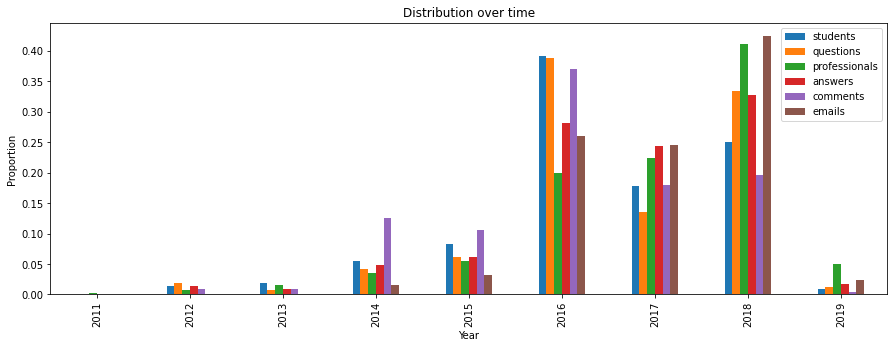

In [47]:
plt_professionals = (professionals.groupby([professionals['professionals_date_joined'].dt.year]).size()/len(professionals.index))
plt_students = (students.groupby([students['students_date_joined'].dt.year]).size()/len(students.index))
plt_questions = (questions.groupby([questions['questions_date_added'].dt.year]).size()/len(questions.index))
plt_answers = (answers.groupby([answers['answers_date_added'].dt.year]).size()/len(answers.index))
plt_emails = (emails.groupby([emails['emails_date_sent'].dt.year]).size()/len(emails.index))
plt_comments = (comments.groupby([comments['comments_date_added'].dt.year]).size()/len(comments.index))
plt_data = pd.DataFrame({'students':plt_students,
                         'questions': plt_questions,
                         'professionals':plt_professionals,
                        'answers':plt_answers,
                        'comments':plt_comments,
                        'emails':plt_emails})
plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Distribution over time')
plt.show()

If we see after 2016 only data has lots of events.

### Missing values (Professionals)

In [48]:
temp = professionals[['professionals_location', 'professionals_industry', 'professionals_headline']].fillna('Missing')
temp = temp.applymap(lambda x: x if x == 'Missing' else 'Available')
plt_professionals_location = temp.groupby('professionals_location').size()/len(temp.index)
plt_professionals_industry = temp.groupby('professionals_industry').size()/len(temp.index)
plt_professionals_headline = temp.groupby('professionals_headline').size()/len(temp.index)

In [49]:
print(f'''plt_professionals_location - {plt_professionals_location}
        plt_professionals_industry - {plt_professionals_industry}
        plt_professionals_headline - {plt_professionals_headline}
''')

plt_professionals_location - professionals_location
Available    0.889955
Missing      0.110045
dtype: float64
        plt_professionals_industry - professionals_industry
Available    0.908497
Missing      0.091503
dtype: float64
        plt_professionals_headline - professionals_headline
Available    0.926577
Missing      0.073423
dtype: float64



In [50]:
plt_professionals_tags = tag_users['tag_users_user_id'].unique()
plt_professionals_tags = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_tags else 'Missing').rename('professionals_tags')
plt_professionals_tags = plt_professionals_tags.groupby(plt_professionals_tags).size()/len(plt_professionals_tags.index)
plt_professionals_group = group_memberships['group_memberships_user_id'].unique()
plt_professionals_group = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_group else 'Missing').rename('professionals_groups')
plt_professionals_group = plt_professionals_group.groupby(plt_professionals_group).size()/len(plt_professionals_group.index)
plt_professionals_school = school_memberships['school_memberships_user_id'].unique()
plt_professionals_school = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_school else 'Missing').rename('professionals_schools')
plt_professionals_school = plt_professionals_school.groupby(plt_professionals_school).size()/len(plt_professionals_school.index)

In [51]:
temp = professionals[['professionals_answers_count', 'professionals_comments_count']]
temp = temp.applymap(lambda x: 'Available' if x > 0 else 'Missing')
plt_professionals_answers = temp.groupby('professionals_answers_count').size()/len(temp.index)
plt_professionals_comments = temp.groupby('professionals_comments_count').size()/len(temp.index)

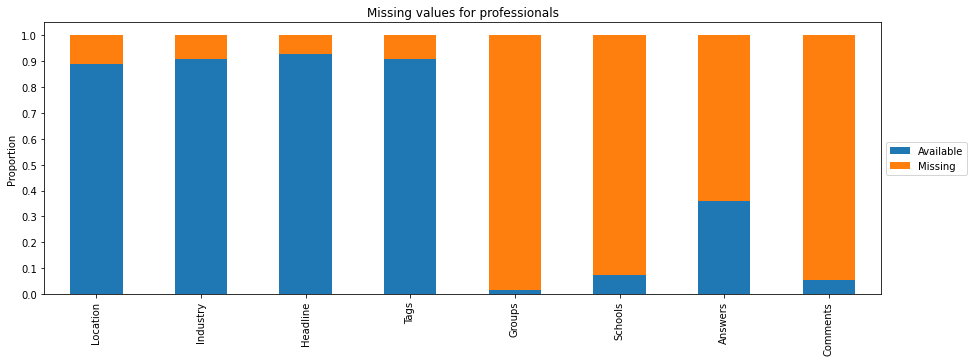

,Available,Missing
Location,0.889955,0.110045
Industry,0.908497,0.091503
Headline,0.926577,0.073423
Tags,0.909136,0.090864
Groups,0.017477,0.982523
Schools,0.075341,0.924659
Answers,0.357594,0.642406
Comments,0.052359,0.947641


In [52]:
plt_data = pd.DataFrame({'Location': plt_professionals_location,
                        'Industry': plt_professionals_industry,
                        'Headline': plt_professionals_headline,
                        'Tags': plt_professionals_tags,
                        'Groups': plt_professionals_group,
                        'Schools': plt_professionals_school,
                        'Answers': plt_professionals_answers,
                        'Comments': plt_professionals_comments,})

plt_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for professionals')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_data.T

### Missing Values (Student)

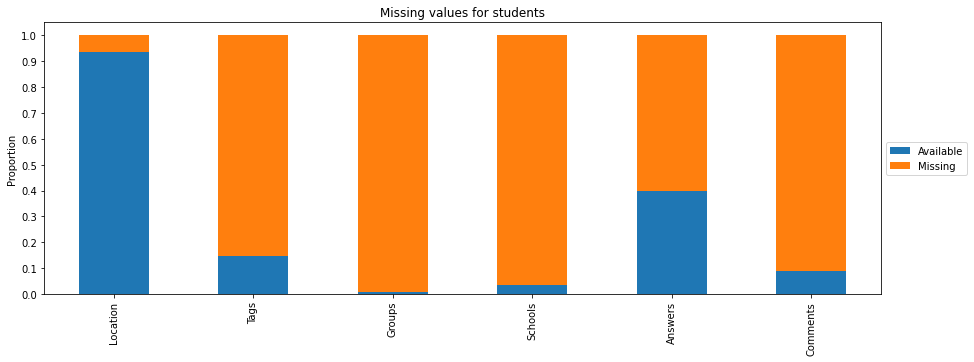

,Available,Missing
Location,0.934358,0.065642
Tags,0.148784,0.851216
Groups,0.007588,0.992412
Schools,0.034226,0.965774
Answers,0.397275,0.602725
Comments,0.087921,0.912079


In [53]:
temp = students[['students_location']].fillna('Missing')
temp = temp.applymap(lambda x: x if x == 'Missing' else 'Available')
plt_students_location = temp.groupby('students_location').size()/len(temp.index)

plt_students_tags = tag_users['tag_users_user_id'].unique()
plt_students_tags = students['students_id'].apply(lambda x: 'Available' if x in plt_students_tags else 'Missing').rename('students_tags')
plt_students_tags = plt_students_tags.groupby(plt_students_tags).size()/len(plt_students_tags.index)
plt_students_group = group_memberships['group_memberships_user_id'].unique()
plt_students_group = students['students_id'].apply(lambda x: 'Available' if x in plt_students_group else 'Missing').rename('students_groups')
plt_students_group = plt_students_group.groupby(plt_students_group).size()/len(plt_students_group.index)
plt_students_school = school_memberships['school_memberships_user_id'].unique()
plt_students_school = students['students_id'].apply(lambda x: 'Available' if x in plt_students_school else 'Missing').rename('students_schools')
plt_students_school = plt_students_school.groupby(plt_students_school).size()/len(plt_students_school.index)

temp = students[['students_questions_count', 'students_comments_count']]
temp = temp.applymap(lambda x: 'Available' if x > 0 else 'Missing')
plt_students_questions = temp.groupby('students_questions_count').size()/len(temp.index)
plt_students_comments = temp.groupby('students_comments_count').size()/len(temp.index)

plt_data = pd.DataFrame({'Location': plt_students_location,
                        'Tags': plt_students_tags,
                        'Groups': plt_students_group,
                        'Schools': plt_students_school,
                        'Answers': plt_students_questions,
                        'Comments': plt_students_comments,})

plt_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for students')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_data.T

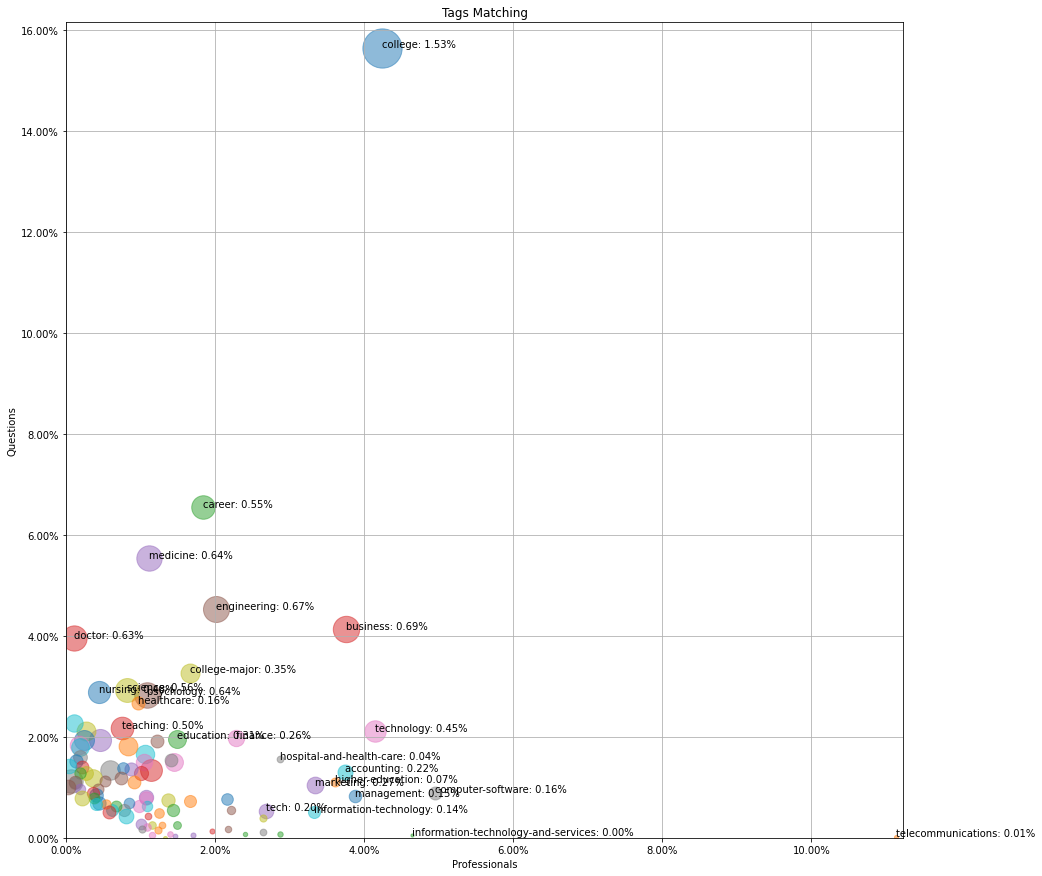

In [54]:
students_tags = tag_users[tag_users['tag_users_user_id'].isin(students['students_id'])]
students_tags = pd.merge(students_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
students_tags['user_type'] = 'student'

professionals_tags = tag_users[tag_users['tag_users_user_id'].isin(professionals['professionals_id'])]
professionals_tags = pd.merge(professionals_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
professionals_tags['user_type'] = 'professional'

questions_tags = tag_questions
questions_tags = pd.merge(questions_tags, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
questions_tags['user_type'] = 'question'

plt_data = pd.concat([students_tags, professionals_tags, questions_tags])
plt_data = plt_data[['tags_tag_name', 'user_type']].pivot_table(index='tags_tag_name', columns='user_type', aggfunc=len, fill_value=0)
plt_data['professional'] = plt_data['professional'] / professionals.shape[0]
plt_data['student'] = plt_data['student'] / students.shape[0]
plt_data['question'] = plt_data['question'] / questions.shape[0]
plt_data['sum'] = (plt_data['professional'] + plt_data['student'] + plt_data['question'])
plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)

# Bubble chart
fig, ax = plt.subplots(facecolor='w',figsize=(15, 15))
ax.set_xlabel('Professionals')
ax.set_ylabel('Questions')
ax.set_title('Tags Matching')
ax.set_xlim([0, max(plt_data['professional'])+0.001])
ax.set_ylim([0, max(plt_data['question'])+0.005])
import matplotlib.ticker as mtick
ax.xaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.yaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.grid(True)
i = 0
for key, row in plt_data.iterrows():
    ax.scatter(row['professional'], row['question'], s=10+row['student']*10**5, alpha=.5)
    if i < 25:
        ax.annotate('{}: {:.2%}'.format(key, row['student']), xy=(row['professional'], row['question']))
    i += 1
plt.show()

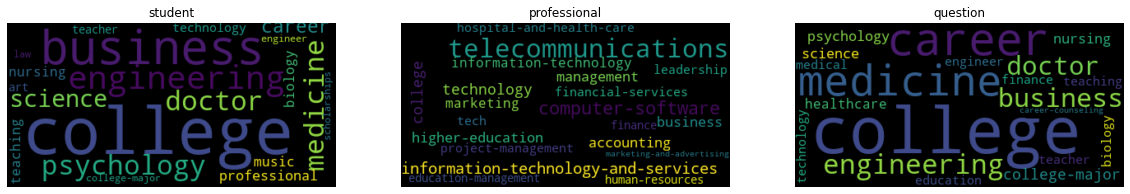

In [55]:
# Wordcloud
plt.figure(figsize=(20, 20))
wordloud_values = ['student', 'professional', 'question']
axisNum = 1
for wordcloud_value in wordloud_values:
    wordcloud = WordCloud(margin=0, max_words=20, random_state=seed).generate_from_frequencies(plt_data[wordcloud_value])
    ax = plt.subplot(1, 3, axisNum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum += 1
plt.show()    

### First activity after registration

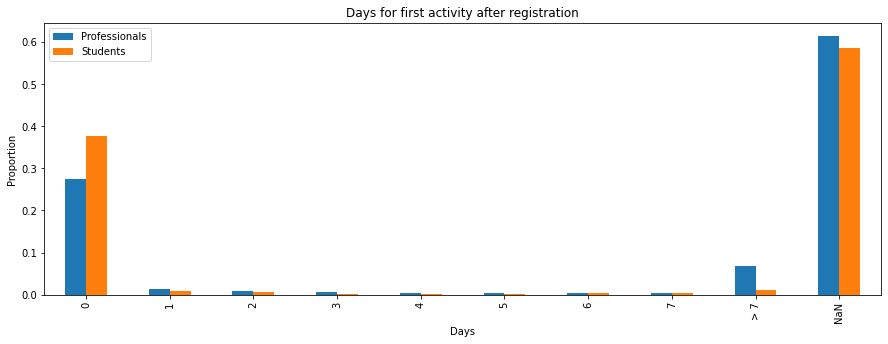

In [56]:
plt_professionals = professionals
plt_professionals = plt_professionals[(plt_professionals['professionals_date_joined'] >= '01-01-2016') & (plt_professionals['professionals_date_joined'] <= '30-06-2018')]
plt_professionals = (plt_professionals['date_first_activity'] - plt_professionals['professionals_date_joined']).dt.days.fillna(9999).astype(int)
plt_professionals = plt_professionals.groupby(plt_professionals).size()/len(plt_professionals.index)
plt_professionals = plt_professionals.rename(lambda x: 0 if x < 0.0 else x)
plt_professionals = plt_professionals.rename(lambda x: x if x <= 7.0 or x == 9999 else '> 7')
plt_professionals = plt_professionals.rename({9999:'NaN'})
plt_professionals = plt_professionals.groupby(level=0).sum()

plt_students = students
plt_students = plt_students[(plt_students['students_date_joined'] >= '01-01-2016') & (plt_students['students_date_joined'] <= '30-06-2018')]
plt_students = (plt_students['date_first_activity'] - plt_students['students_date_joined']).dt.days.fillna(9999).astype(int)
plt_students = plt_students.groupby(plt_students).size()/len(plt_students.index)
plt_students = plt_students.rename(lambda x: 0 if x < 0.0 else x)
plt_students = plt_students.rename(lambda x: x if x <= 7.0 or x == 9999 else '> 7')
plt_students = plt_students.rename({9999:'NaN'})
plt_students = plt_students.groupby(level=0).sum()

plt_data = pd.DataFrame({'Professionals': plt_professionals,
                        'Students': plt_students})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Days')
plt.ylabel('Proportion')
plt.title('Days for first activity after registration')
plt.show()

### Last Activity

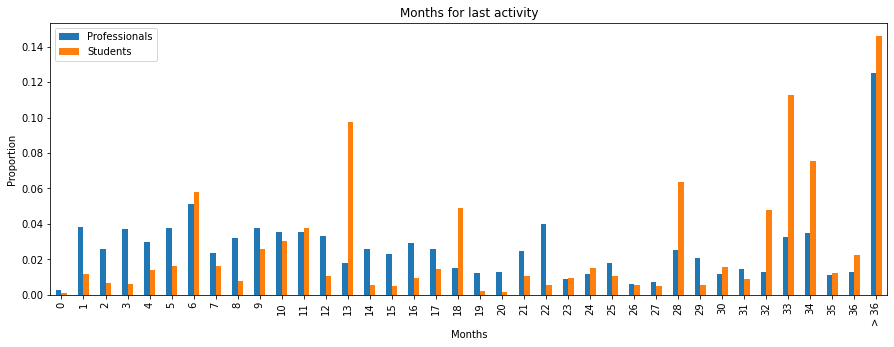

In [57]:
plt_professionals = ((actual_date - professionals['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_professionals = plt_professionals.groupby(plt_professionals).size()/len(plt_professionals.index)
plt_professionals = plt_professionals.rename(lambda x: 0 if x < 0.0 else x)
plt_professionals = plt_professionals.rename(lambda x: x if x <= 36.0 or x == 9999 else '> 36')
plt_professionals = plt_professionals.rename({9999:'NaN'})
plt_professionals = plt_professionals.groupby(level=0).sum()

plt_students = ((actual_date - students['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_students = plt_students.groupby(plt_students).size()/len(plt_students.index)
plt_students = plt_students.rename(lambda x: 0 if x < 0.0 else x)
plt_students = plt_students.rename(lambda x: x if x <= 36.0 or x == 9999 else '> 36')
plt_students = plt_students.rename({9999:'NaN'})
plt_students = plt_students.groupby(level=0).sum()

plt_data = pd.DataFrame({'Professionals': plt_professionals,
                        'Students': plt_students})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Months')
plt.ylabel('Proportion')
plt.title('Months for last activity')
plt.show()

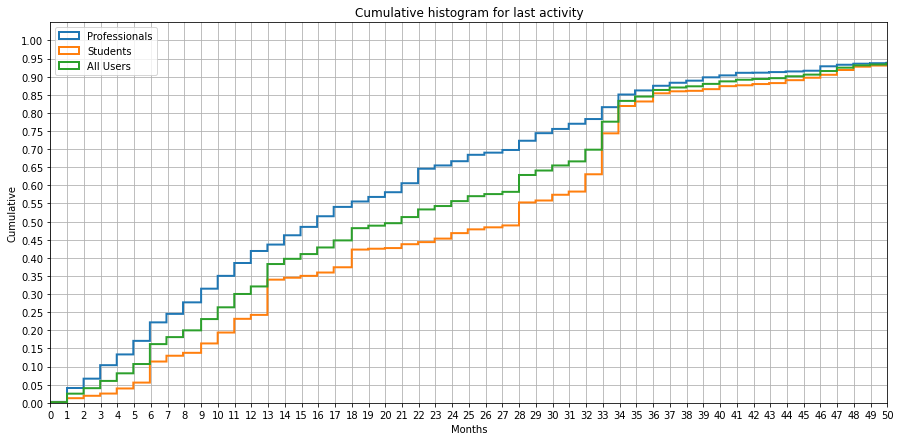

In [58]:
plt_professionals = ((actual_date - professionals['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_students = ((actual_date - students['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_data = pd.DataFrame({'Professionals': plt_professionals, 'Students': plt_students})
plt_total = pd.concat([plt_data['Professionals'], plt_data['Students']]).rename('All Users')
plt_data.plot(kind='hist', bins=1000, density=True, histtype='step', cumulative=True, figsize=(15, 7), lw=2, grid=True)
plt_total.plot(kind='hist', bins=1000, density=True, histtype='step', cumulative=True, figsize=(15, 7), lw=2, grid=True)
plt.xlabel('Months')
plt.ylabel('Cumulative')
plt.title('Cumulative histogram for last activity')
plt.legend(loc='upper left')
plt.xlim([0, 50])
plt.xticks(range(0, 51, 1))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

### First answer for questions 

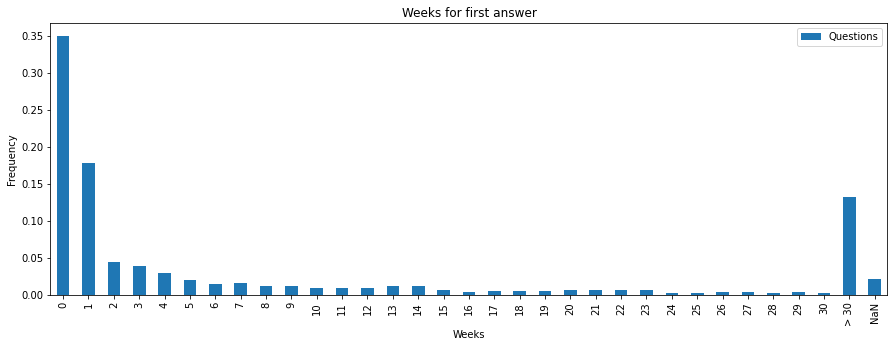

In [60]:
plt_questions = questions
plt_questions = plt_questions[(plt_questions['questions_date_added'] >= '01-01-2016') & (plt_questions['questions_date_added'] <= '30-06-2018')]
plt_questions = ((plt_questions['questions_first_answers'] - plt_questions['questions_date_added']).dt.days/7).fillna(9999).apply(lambda x: math.ceil(x)).astype(int)
plt_questions = plt_questions.groupby(plt_questions).size()/len(plt_questions.index)
plt_questions = plt_questions.rename(lambda x: 0 if x < 0.0 else x)
plt_questions = plt_questions.rename(lambda x: x if x <= 30.0 or x == 9999 else '> 30')
plt_questions = plt_questions.rename({9999:'NaN'})
plt_questions = plt_questions.groupby(level=0).sum()

plt_data = pd.DataFrame({'Questions': plt_questions})
plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Weeks')
plt.ylabel('Frequency')
plt.title('Weeks for first answer')
plt.show()

### Question response time

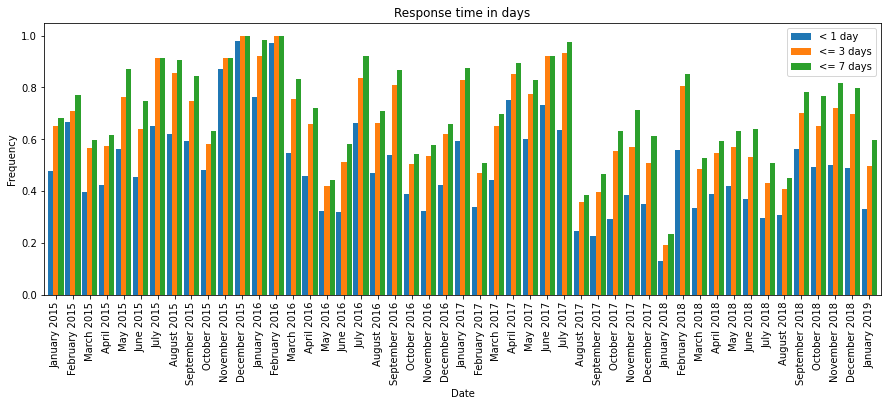

In [61]:
plt_data = questions[['questions_date_added', 'questions_first_answers']]
plt_data = plt_data[plt_data['questions_date_added'] > '2015-01-01']
plt_data['answer_time'] = (plt_data['questions_first_answers'] - plt_data['questions_date_added'])
plt_data['days'] = (plt_data['questions_first_answers'] - plt_data['questions_date_added']).dt.days
plt_data['date'] = plt_data['questions_date_added'].dt.strftime('%B %Y')
plt_data['date'] = plt_data['date'].apply(lambda x: str(datetime.strptime(x, "%B %Y")))  
plt_data['date2'] = plt_data['questions_date_added'].dt.strftime('%B %Y')

plt_data_1 = (plt_data[plt_data['days'] <= 0].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('< 1 day')
plt_data_2 = (plt_data[plt_data['days'] <= 3].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('<= 3 days')
plt_data_3 = (plt_data[plt_data['days'] <= 7].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('<= 7 days')
plt_data = pd.concat([plt_data_1, plt_data_2, plt_data_3], axis=1).fillna(0)
plt_data.index = plt_data.index.droplevel('date')

plt_data.plot(kind='bar', figsize=(15, 5), width=0.9)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Response time in days')
plt.show()

### Email response time

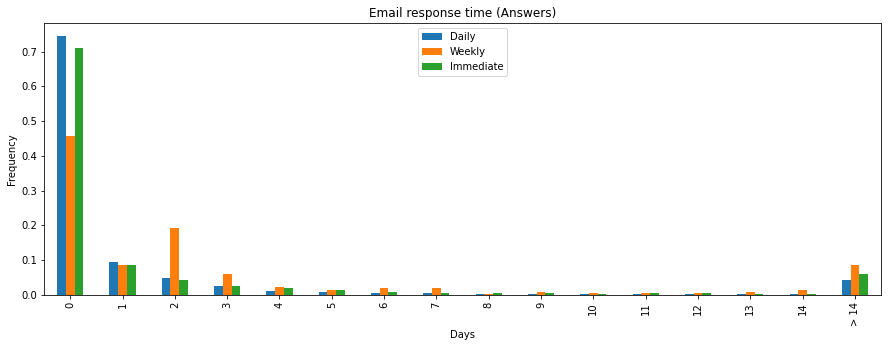

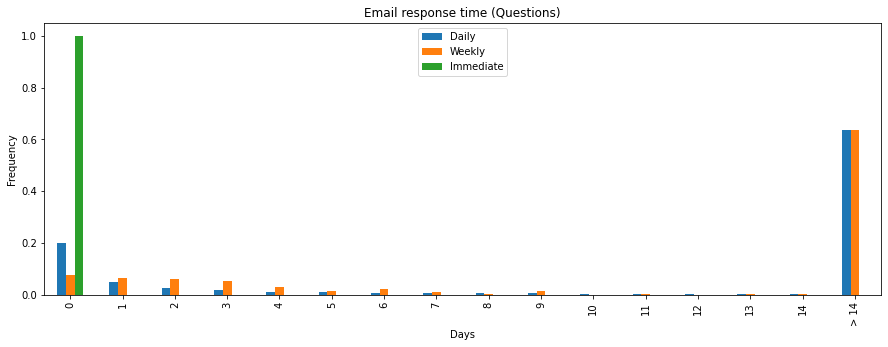

In [62]:
plt_email_response = emails_response[(emails_response['emails_date_sent'] >= '01-01-2016')].dropna()

plt_data = pd.DataFrame()
title_mapping = {'time_delta_email_answer':'Answers', 'time_delta_question_email':'Questions'}
for qa in ['time_delta_email_answer', 'time_delta_question_email']:
    plt_data = pd.DataFrame()
    for fl in ['email_notification_daily', 'email_notification_weekly', 'email_notification_immediate']:
        temp = plt_email_response[plt_email_response['emails_frequency_level'] == fl]
        temp = temp[qa].dt.days.astype(int)
        temp = temp.groupby(temp).size()/len(temp.index)
        temp = temp.rename(lambda x: 0 if x < 0.0 else x)
        temp = temp.rename(lambda x: x if x <= 14.0 else '> 14')
        temp = temp.groupby(level=0).sum() 
        plt_data = pd.concat([plt_data, temp], axis=1, sort=False)
    plt_data.columns = ['Daily', 'Weekly', 'Immediate']

    plt_data.plot(kind='bar', figsize=(15, 5))
    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.title('Email response time ({})'.format(title_mapping[qa]))
    plt.legend(loc='upper center')
    plt.show()

## Topic Model (LDA) 

#### LDA params

In [63]:
# Gensim Dictionary Filter
extremes_no_below = 20
extremes_no_above = 0.6
extremes_keep_n = 8000

# LDA
num_topics = 21
passes = 15
chunksize = 1000
alpha = 1/50

In [64]:
def get_model_results(ldamodel, corpus, dictionary):
    """ Create doc-topic probabilities table and visualization for the LDA model

    """  
    vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df  

In [65]:
def get_model_wordcloud(ldamodel):
    """ Create a Word Cloud for each topic of the LDA model

    """  
    plot_cols = 3
    plot_rows = math.ceil(num_topics / 3)
    axisNum = 0
    plt.figure(figsize=(5*plot_cols, 3*plot_rows))
    for topicID in range(ldamodel.state.get_lambda().shape[0]):
        #gather most relevant terms for the given topic
        topics_terms = ldamodel.state.get_lambda()
        tmpDict = {}
        for i in range(1, len(topics_terms[0])):
            tmpDict[ldamodel.id2word[i]]=topics_terms[topicID,i]

        # draw the wordcloud
        wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
        axisNum += 1
        ax = plt.subplot(plot_rows, plot_cols, axisNum)

        plt.imshow(wordcloud, interpolation='bilinear')
        title = topicID
        plt.title(title)
        plt.axis("off")
        plt.margins(x=0, y=0)
    plt.show()

In [66]:
def topic_query(data, query):
    """ Get Documents matching the query with the doc-topic probabilities

    """  
    result = data
    result['sort'] = 0
    for topic in query:
        result = result[result[topic] >= query[topic]]
        result['sort'] += result[topic]
    result = result.sort_values(['sort'], ascending=False)
    result = result.drop('sort', axis=1)
    result = result.head(5)
    return result

In [67]:
def get_text_topics(text, top=20):
    """ Get the topics probabilities for a text and highlight relevant words

    """    
    def token_topic(token):
        return topic_words.get(token, -1)
    
    colors = ['\033[46m', '\033[45m', '\033[44m', '\033[43m', '\033[42m', '\033[41m', '\033[47m']    
    nlp_tokens = nlp_preprocessing([text])

    bow_text = [lda_dic.doc2bow(doc) for doc in nlp_tokens]
    bow_text = lda_tfidf[bow_text]
    topic_text = lda_model.get_document_topics(bow_text)
    topic_text = pd.DataFrame.from_records([{v:k for v, k in row} for row in topic_text])
    
    print('Question:')
    topic_words = []
    topic_labeled = 0
    for topic in topic_text.columns.values:
        topic_terms = lda_model.get_topic_terms(topic, top)
        topic_words = topic_words+[[topic_labeled, lda_dic[pair[0]], pair[1]] for pair in topic_terms]
        topic_labeled += 1
    topic_words = pd.DataFrame(topic_words, columns=['topic', 'word', 'value']).pivot(index='word', columns='topic', values='value').idxmax(axis=1)
    nlp_doc = nlp(text)
    text_highlight = ''.join([x.string if token_topic(x.lemma_.lower()) <0  else colors[token_topic(x.lemma_.lower()) % len(colors)] + x.string + '\033[0m' for x in nlp_doc])
    print(text_highlight) 
    
    print('\nTopics:')
    topic_labeled = 0
    for topic in topic_text:
        print(colors[topic_labeled % len(colors)]+'Topic '+str(topic)+':', '{0:.2%}'.format(topic_text[topic].values[0])+'\033[0m')
        topic_labeled += 1

    # Plot Pie chart
    plt_data = topic_text
    plt_data.columns = ['Topic '+str(c) for c in plt_data.columns]
    plt_data['Others'] = 1-plt_data.sum(axis=1)
    plt_data = plt_data.T
    plt_data.plot(kind='pie', y=0, autopct='%.2f')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Topics Probabilities')
    plt.show()

In [68]:
%%time
lda_tokens = questions['nlp_tokens']
# Gensim Dictionary
lda_dic = gensim.corpora.Dictionary(lda_tokens)
lda_dic.filter_extremes(no_below=extremes_no_below, no_above=extremes_no_above, keep_n=extremes_keep_n)
lda_corpus = [lda_dic.doc2bow(doc) for doc in lda_tokens]

lda_tfidf = gensim.models.TfidfModel(lda_corpus)
lda_corpus = lda_tfidf[lda_corpus]

# Create LDA Model
lda_model = gensim.models.ldamodel.LdaModel(lda_corpus, num_topics=num_topics, 
                                            id2word = lda_dic, passes=passes,
                                            chunksize=chunksize,update_every=0,
                                            alpha=alpha, random_state=seed)

# Create Visualization and Doc-Topic Probabilities
lda_vis, lda_result = get_model_results(lda_model, lda_corpus, lda_dic)
lda_questions = questions[['questions_id', 'questions_title', 'questions_body']]
lda_questions = pd.concat([lda_questions, lda_result.add_prefix('Topic_')], axis=1)

Wall time: 7min 57s


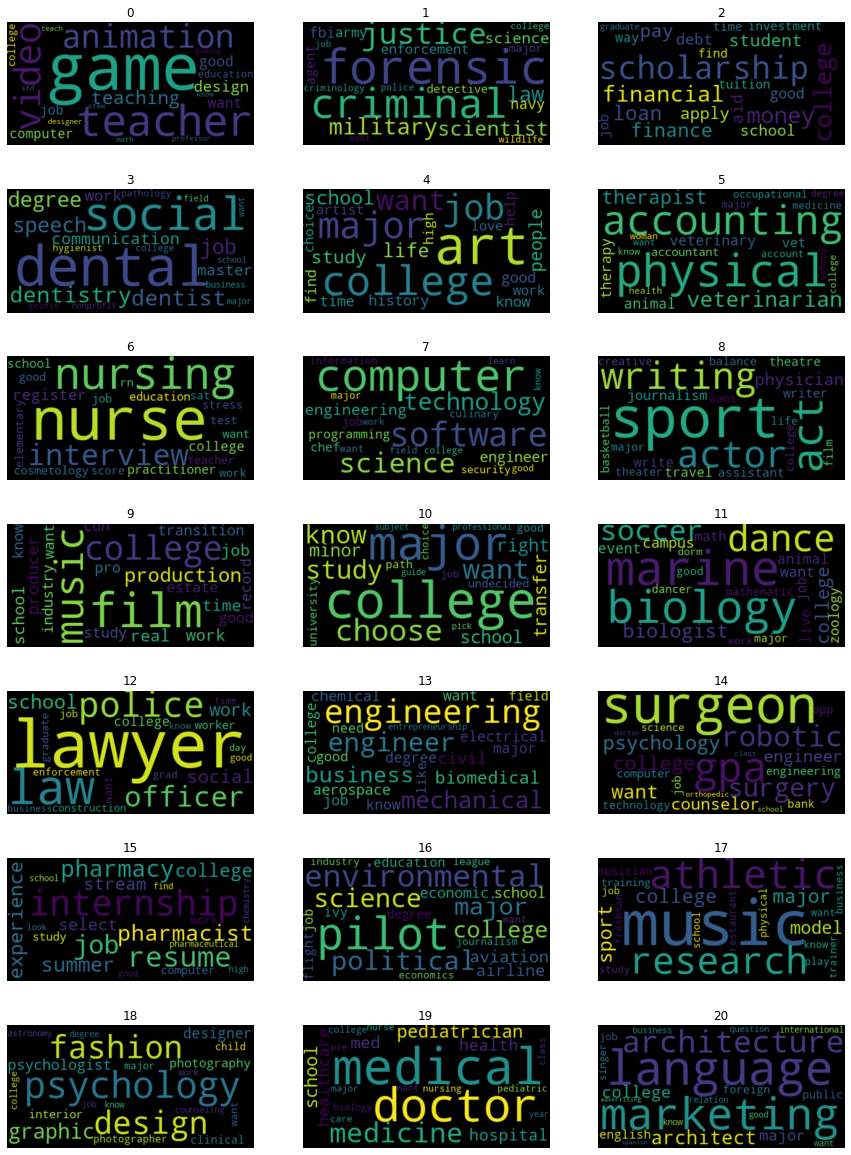

In [69]:
get_model_wordcloud(lda_model)

# Topics 
Each wordcloud shows a topic and the top words who define the topic. Here some examples:<br>
Topic 3 is for payment (loan, finance, money, pay, debt, ...)<br>
Topic 4 is for veterinary (veterinary, animal, vet, medicine, ...)<br>
Topic 7 is for architecture (architect, construction, ...) and marketing (marketing, advertising, communication, ...)<br>
Topic 14 is for sport (sport, soccer, athletic, basketball, ...)<br>
Topic 16 is for engieers (eingineering, mechanical, aerospace, electrical, ...)<br>
Topic 17 is for computer science (computer, software, programming, ...)<br>
Topic 18 is for health (medicine, doctor, nurse, medical, ...)<br>

In [70]:
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.081262 -0.001709  1       1        3.842825
1      0.025790  0.016207  2       1        3.664243
2     -0.067300 -0.047650  3       1        9.249584
3      0.008164  0.002876  4       1        3.194077
4     -0.021308 -0.023729  5       1        6.869128
5     -0.040764  0.066185  6       1        4.100809
6     -0.092353  0.041297  7       1        5.023910
7      0.117713  0.024116  8       1        6.474270
8     -0.020356 -0.093244  9       1        4.599818
9     -0.026077 -0.076226  10      1        2.942920
10    -0.050627  0.008890  11      1        5.517896
11    -0.015186 -0.040998  12      1        2.981186
12    -0.025378  0.003226  13      1        3.965810
13     0.069903  0.055356  14      1        6.558537
14     0.034696  0.060699  15      1        2.573694
15     0.034367  0.017927  16      1        4.797832
16     0.019011  0.007625  17      1        3.459618
17    -0.011798 -0.047610  18      1        2.828448
18     0.034374 -0.009444  19      1        4.154614
19    -0.091179  0.098526  20      1        7.811432
20     0.037044 -0.062320  21      1        5.389359, topic_info=            Term        Freq       Total Category  logprob  loglift
114  engineering  535.000000  535.000000  Default  30.0000  30.0000
511  nurse        316.000000  316.000000  Default  29.0000  29.0000
288  computer     414.000000  414.000000  Default  28.0000  28.0000
50   scholarship  319.000000  319.000000  Default  27.0000  27.0000
64   music        196.000000  196.000000  Default  26.0000  26.0000
..     ...               ...         ...      ...      ...      ...
136  school       22.171387   632.415588  Topic21 -5.2227  -0.4300 
67   people       19.459658   251.176208  Topic21 -5.3531   0.3629 
240  look         19.134501   278.743134  Topic21 -5.3700   0.2419 
52   student      19.560221   366.947357  Topic21 -5.3480  -0.0110 
198  high         18.921373   382.729553  Topic21 -5.3812  -0.0863 

[1207 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
918   5      0.157540  acceptable
918   16     0.157540  acceptable
918   19     0.472619  acceptable
476   1      0.048174  account   
476   2      0.016058  account   
...  ..           ...      ...   
1583  12     0.848552  zoologist 
561   2      0.121050  zoology   
561   4      0.040350  zoology   
561   6      0.040350  zoology   
561   12     0.726302  zoology   

[6758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

### Document-Topic Probabilities

In [71]:
lda_questions.head(5).dropna(axis=1, how='all').T

,0,1,2,3,4
questions_id,332a511f1569444485cf7a7a556a5e54,eb80205482e4424cad8f16bc25aa2d9c,4ec31632938a40b98909416bdd0decff,2f6a9a99d9b24e5baa50d40d0ba50a75,5af8880460c141dbb02971a1a8369529
questions_title,Teacher career question,I want to become an army officer. What can I do to become an army officer?,Will going abroad for your first job increase your chances for jobs back home?,"To become a specialist in business management, will I have to network myself?",Are there any scholarships out there for students that are first generation and live in GA?
questions_body,What is a maths teacher? what is a maths teacher useful? #college #professor #lecture,I am Priyanka from Bangalore . Now am in 10th std . When I go to college I should not get confused on what I want to take to become army officer. So I am asking this question #military #army,"I'm planning on going abroad for my first job. It will be a teaching job and I don't have any serious career ideas. I don't know what job I would be working if I stay home instead so I'm assuming staying or leaving won't makeba huge difference in what I care about, unless I find something before my first job. I can think of ways that going abroad can be seen as good and bad. I do not know which side respectable employers willl side with. #working-abroad #employment- #overseas",i hear business management is a hard way to get a job if you're not known in the right areas. #business #networking,I'm trying to find scholarships for first year students but they all seem to be for other states besides GA. Any help??\r\n\r\n#college\r\n#scholarships \r\n#highschoolsenior \r\n#firstgeneration \r\n
Topic_0,0.859036,NaN,NaN,NaN,NaN
Topic_1,NaN,0.842299,NaN,NaN,NaN
Topic_2,NaN,NaN,0.917871,NaN,0.871517
Topic_13,NaN,NaN,NaN,0.888072,NaN


#### For Example 1

Question:
I will finish my college next year and would like to start a career as a Data Scientist. 

What is the best way to become a good Data Scientist? #data-science

Topics:
Topic 7: 84.90%


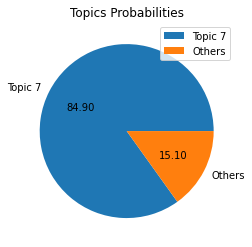

In [72]:
query_text = 'I will finish my college next year and would like to start a career as a Data Scientist. \n\n'\
            +'What is the best way to become a good Data Scientist? #data-science'
get_text_topics(query_text, 100)